In [1]:
import numpy as np
import pandas as pd

In [57]:
data_train = pd.read_csv('./train.csv')
data_test = pd.read_csv('./test.csv')
data_train

,label,email
0,spam,attn i am bulawa mulete jr the son of mr steve...
1,ham,That depends. How would you like to be treated...
2,ham,"Wen u miss someone, the person is definitely s..."
3,spam,Win the newest “Harry Potter and the Order of ...
4,ham,Where are you lover ? I need you ...
...,...,...
5858,ham,Eek that's a lot of time especially since Amer...
5859,ham,"Aight I'll grab something to eat too, text me ..."
5860,ham,I havent lei.. Next mon can?
5861,ham,Ok but tell me half an hr b4 u come i need 2 p...


In [58]:
data_train = data_train.dropna(subset=['email'])
# data_train = data_train.dropna(subset=['label'])
data_test = data_test.dropna(subset=['email'])
# data_test = data_test.dropna(subset=['label'])


In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

In [59]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(data_train['email'])
y_train = data_train['label']
X_test = vectorizer.transform(data_test['email'])
y_test = data_test['label']
X_train

<5844x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 233366 stored elements in Compressed Sparse Row format>

In [61]:
# Suppress warnings
warnings.filterwarnings('ignore')

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Здесь были проверенны методы и был выбранн самый лучший по скорости и точности. Иначе если это запускать займёт более 20 минут.
# Models and their hyperparameter grids
# models = {
    # 'SVM': {
    #     'model': SVC(),
    #     'params': {
    #         'kernel': ['linear'],
    #         'C': [10, 100, 200],
    #         'gamma': ['scale']
    #     }
    #   },
#       'Logistic Regression': {
#           'model': LogisticRegression(max_iter=1000),
#           'params': {
#               'C': [0.01, 0.1, 1, 10, 100]
#           }
#       },'Multinomial NB': {
#       'model': MultinomialNB(),
#       'params': {
#           'alpha': [0.01, 0.1, 1, 10]
#       }
#       },
#       'Random Forest': {
#           'model': RandomForestClassifier(),
#           'params': {
#               'n_estimators': [50, 100, 200, 500],
#               'max_depth': [None, 10, 20, 30],
#               'min_samples_split': [2, 5, 10]
#           }
#       },
#       'Gradient Boosting': {
#           'model': GradientBoostingClassifier(),
#           'params': {
#               'n_estimators': [50, 100, 200, 500],
#               'learning_rate': [0.01, 0.1, 0.2, 0.5],
#               'max_depth': [3, 5, 7, 9]
#           }
#       },
#         'LightGBM': {
#             'model': LGBMClassifier(verbose=-1),
#             'params': {
#                 'n_estimators': [50, 100, 200, 500],
#                 'learning_rate': [0.01, 0.1, 0.2, 0.5],
#                 'max_depth': [-1, 5, 10, 20]
#             }
#       }
# }
models = {    'SVM': {
        'model': SVC(),
        'params': {
            'kernel': ['linear'],
            'C': [10, 100, 200],
            'gamma': ['scale']
        }
      }}

In [ ]:
def evaluate_model(model, param_grid, X_train, y_train, X_test, y_test, cv_splits=5):
    # Выполнение поиска по сетке с кросс-валидацией
    grid_search = GridSearchCV(model, param_grid, cv=cv_splits, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Средняя оценка кросс-валидации
    mean_cv_score = grid_search.best_score_

    # Обучение лучшей модели на всем обучающем наборе данных
    best_model.fit(X_train, y_train)

    # Прогнозы на тестовом наборе данных
    y_pred = best_model.predict(X_test)

    # Оценка модели на тестовом наборе данных
    test_accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    return mean_cv_score, test_accuracy, class_report, conf_matrix, grid_search.best_params_

In [64]:
results = {}

for model_name, model_info in models.items():
    mean_cv_score, test_accuracy, class_report, conf_matrix, best_params = evaluate_model(
        model_info['model'], model_info['params'], X_train, y_train_encoded, X_test, y_test_encoded
    )
    results[model_name] = {
        'Mean CV Score': mean_cv_score,
        'Test Accuracy': test_accuracy,
        'Classification Report': class_report,
        'Confusion Matrix': conf_matrix,
        'Best Params': best_params
    }

In [65]:
label_encoder.classes_

array(['ham', 'spam', '{"mode":"full"', nan], dtype=object)

Model: SVM
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Mean Cross-Validation Score: 0.9769
Test Accuracy: 0.9848

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2467
           1       0.97      0.93      0.95       422
           3       0.00      0.00      0.00         0

    accuracy                           0.98      2889
   macro avg       0.65      0.64      0.65      2889
weighted avg       0.99      0.98      0.99      2889



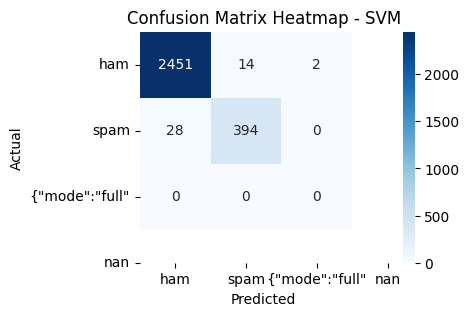


Best Model: SVM with Test Accuracy: 0.9848


In [66]:
best_model_name = None
best_test_accuracy = 0

for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Best Parameters: {result['Best Params']}")
    print(f"Mean Cross-Validation Score: {result['Mean CV Score']:.4f}")
    print(f"Test Accuracy: {result['Test Accuracy']:.4f}")
    print("\nClassification Report:")
    print(result['Classification Report'])
    plt.figure(figsize=(4, 3))
    sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix Heatmap - {model_name}')
    plt.show()

    if result['Test Accuracy'] > best_test_accuracy:
        best_test_accuracy = result['Test Accuracy']
        best_model_name = model_name

print(f"\nBest Model: {best_model_name} with Test Accuracy: {best_test_accuracy:.4f}")